In [61]:
%matplotlib inline
import sklearn
from sklearn.neighbors import NearestNeighbors
from matplotlib.pyplot import imshow
import requests
import random
import os
import base64
from sklearn.decomposition import TruncatedSVD
from keras.models import Model
from hashlib import md5
import pickle
try:
    from urllib import unquote
except ImportError:
    from urllib.parse import unquote
from PIL import Image
import PIL
PIL.Image.MAX_IMAGE_PIXELS = 933120000

import requests
try:
    from io import BytesIO
except ImportError:
    from StringIO import StringIO as BytesIO
from IPython.display import HTML, Image as iPythonImage, display
import numpy as np
from tqdm import tqdm
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.preprocessing import image




In [5]:
query = """SELECT DISTINCT ?pic
WHERE
{
    ?item wdt:P31 ?class . 
    ?class wdt:P18 ?pic
}"""

In [7]:
url = 'https://query.wikidata.org/bigdata/namespace/wdq/sparql'
data = requests.get(url, params={'query': query, 'format': 'json'})

{
  "head" : {
    "vars" : [ "pic" ]
  },
  "results" : {
    "bindings" : [ {
      "pic" : {
        "type" : "uri",
        "value" : "http://commons.wikimedia.org/wiki/Special:FilePath/Breviarium%20Grimani%20-%20November.jpg"
      }
    }, {
      "pic" : {
        "type" : "uri",
        "value" : "http://commons.wikimedia.org/wiki/Special:FilePath/HQ%20SAM%20F.jpg"
      }
    }, {
      "pic" : {
        "type" : "uri",
        "value" : "http://commons.wikimedia.org/wiki/Special:FilePath/Macintosh%20SE%20b.jpg"
      }
    }, {
      "pic" : {
        "type" : "uri",
        "value" : "http://commons.wikimedia.org/wiki/Special:FilePath/Science%20museum%20025%20adjusted.jpg"
      }
    }, {
      "pic" : {
        "type" : "uri",
        "value" : "http://commons.wikimedia.org/wiki/Special:FilePath/Sweet%20Baby%20Kisses%20Family%20Love.jpg"
      }
    }, {
      "pic" : {
        "type" : "uri",
        "value" : "http://commons.wikimedia.org/wiki/Special:FilePath/Gos%20d%27

In [26]:
import json

f = open('text.txt', 'r')
text = f.read()
data = json.loads(text, strict = False)

In [27]:
images = [x['pic']['value'] for x in data['results']['bindings']]
len(images), random.sample(images, 10)

(7673,
 ['http://commons.wikimedia.org/wiki/Special:FilePath/Earth-grazing%20meteoroid%2C%2013%20October%201990%20%282%29.jpg',
  'http://commons.wikimedia.org/wiki/Special:FilePath/Apollo%2015%20Rover%2C%20Irwin.jpg',
  'http://commons.wikimedia.org/wiki/Special:FilePath/Tranby%20house%2049%20gnangarra.jpg',
  'http://commons.wikimedia.org/wiki/Special:FilePath/Hama%20Rikyu%20Tsukiji%20St%20Lukes%20Sumida%20river.jpg',
  'http://commons.wikimedia.org/wiki/Special:FilePath/List-box.png',
  'http://commons.wikimedia.org/wiki/Special:FilePath/Munefuda.jpg',
  'http://commons.wikimedia.org/wiki/Special:FilePath/MiniDachshund1%20wb.jpg',
  'http://commons.wikimedia.org/wiki/Special:FilePath/Sigmodon%20hispidus1.jpg',
  'http://commons.wikimedia.org/wiki/Special:FilePath/Rockingham%20Motor%20Speedway.svg',
  'http://commons.wikimedia.org/wiki/Special:FilePath/Lonesome%20George%20-Pinta%20giant%20tortoise%20-Santa%20Cruz.jpg'])

In [28]:
IMAGE_DIR = 'wp_images'
if not os.path.isdir(IMAGE_DIR):
    os.mkdir(IMAGE_DIR)

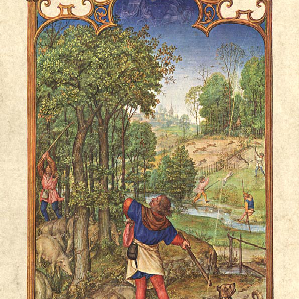

In [29]:
def center_crop_resize(img, new_size):
    w, h = img.size
    s = min(w, h)
    y = (h - s) // 2
    x = (w - s) // 2
    img = img.crop((x, y, s, s))
    return img.resize((new_size, new_size))

def fetch_image(image_cache, image_url):
    image_name = image_url.rsplit('/', 1)[-1]
    local_name = image_name.rsplit('.', 1)[0] + '.jpg'
    local_path = os.path.join(image_cache, local_name)
    if os.path.isfile(local_path):
        img = Image.open(local_path)
        img.load()
        return center_crop_resize(img, 299)
    image_name = unquote(image_name).replace(' ', '_')
    m = md5()
    m.update(image_name.encode('utf8'))
    c = m.hexdigest()
    for prefix in 'http://upload.wikimedia.org/wikipedia/en', 'http://upload.wikimedia.org/wikipedia/commons':
        url = '/'.join((prefix, c[0], c[0:2], image_name))
        r = requests.get(url)
        if r.status_code != 404:
            try:
                img = Image.open(BytesIO(r.content))
                if img.mode != 'RGB':
                    img = img.convert('RGB')
                img.save(local_path)
                return center_crop_resize(img, 299)
            except IOError:
                pass
    return None

fetch_image(IMAGE_DIR, images[0])

In [35]:
valid_images = []
valid_image_names = []
for image_name in tqdm(images):
    img = fetch_image(IMAGE_DIR, image_name)
    if img:
        valid_images.append(img)
        valid_image_names.append(image_name)


  6%|▋         | 494/7673 [01:55<38:56,  3.07it/s]


 13%|█▎        | 995/7673 [03:40<34:37,  3.21it/s]


 19%|█▉        | 1485/7673 [05:31<07:40, 13.43it/s]


 23%|██▎       | 1770/7673 [14:32<8:49:20,  5.38s/it]


 25%|██▍       | 1912/7673 [28:02<8:17:52,  5.19s/it]


 27%|██▋       | 2054/7673 [41:45<8:26:49,  5.41s/it]


 29%|██▊       | 2197/7673 [54:38<10:37:44,  6.99s/it]


 30%|███       | 2337/7673 [1:08:25<7:37:50,  5.15s/it]


 32%|███▏      | 2475/7673 [1:22:26<11:52:28,  8.22s/it]


 34%|███▍      | 2613/7673 [1:36:40<7:39:24,  5.45s/it]


 36%|███▌      | 2751/7673 [1:51:14<10:39:03,  7.79s/it]


 38%|███▊      | 2889/7673 [2:07:13<7:20:45,  5.53s/it]


 39%|███▉      | 3026/7673 [2:23:54<7:52:47,  6.10s/it]


 41%|████      | 3163/7673 [2:41:50<8:59:12,  7.17s/it]


 43%|████▎     | 3301/7673 [2:58:02<7:03:12,  5.81s/it]


 45%|████▍     | 3439/7673 [3:10:54<6:12:10,  5.27s/it]


 45%|████▌     | 3470/7673 [3:14:17<8:22:09,  7.17s/it]/anaconda3/lib/python3.7/site-packages/PIL/Image.py:930: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +

 47%|████▋     | 3574/7673 [3:24:47<6:33:13,  5.76s/it]


 48%|████▊     | 3712/7673 [3:37:57<5:29:26,  4.99s/it]


 50%|█████     | 3848/7673 [3:52:55<6:33:36,  6.17s/it]/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))



 52%|█████▏    | 3985/7673 [4:13:00<8:08:01,  7.94s/it]


 54%|█████▎    | 4121/7673 [4:44:59<14:43:03, 14.92s/it]


 55%|█████▌    | 4258/7673 [5:22:33<4:00:24,  4.22s/it]


 57%|█████▋    | 4396/7673 [5:32:52<4:34:40,  5.03s/it]


 59%|█████▉    | 4534/7673 [5:43:27<3:12:55,  3.69s/it]


 61%|██████    | 4673/7673 [5:52:30<3:49:12,  4.58s/it]


 63%|██████▎   | 4811/7673 [6:01:22<2:29:18,  3.13s/it]


 64%|██████▍   | 4949/7673 [6:10:17<3:46:19,  4.99s/it]


 66%|██████▋   | 5087/7673 [6:19:08<4:02:54,  5.64s/it]


 68%|██████▊   | 5225/7673 [6:28:42<2:42:55,  3.99s/it]


 70%|██████▉   | 5363/7673 [6:37:48<2:26:00,  3.79s/it]


 72%|███████▏  | 5493/7673 [6:47:05<3:05:48,  5.11s/it]/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:747: UserWarning: Possibly corrupt EXIF data.  Expecting to read 109 bytes but only got 0. Skipping tag 33285
  " Skipping tag %s" % (size, len(data), tag))
/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:747: UserWarning: Possibly corrupt EXIF data.  Expecting to read 117 bytes but only got 0. Skipping tag 33285
  " Skipping tag %s" % (size, len(data), tag))
/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:747: UserWarning: Possibly corrupt EXIF data.  Expecting to read 165 bytes but only got 0. Skipping tag 37125
  " Skipping tag %s" % (size, len(data), tag))
/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:747: UserWarning: Possibly corrupt EXIF data.  Expecting to read 173 bytes but only got 0. Skipping tag 37386
  " Skipping tag %s" % (size, len(data), tag))
/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:747: Us

 73%|███████▎  | 5631/7673 [6:56:58<3:14:41,  5.72s/it]


 75%|███████▌  | 5769/7673 [7:07:13<1:45:57,  3.34s/it]


 77%|███████▋  | 5907/7673 [7:17:26<1:55:07,  3.91s/it]


 79%|███████▉  | 6046/7673 [7:28:08<2:07:10,  4.69s/it]


 81%|████████  | 6184/7673 [7:39:21<2:31:13,  6.09s/it]


 82%|████████▏ | 6322/7673 [7:51:21<1:43:11,  4.58s/it]


 84%|████████▍ | 6460/7673 [8:05:32<1:55:51,  5.73s/it]


 86%|████████▌ | 6598/7673 [8:20:15<2:04:08,  6.93s/it]


 88%|████████▊ | 6736/7673 [8:35:40<1:29:35,  5.74s/it]


 90%|████████▉ | 6874/7673 [8:56:48<1:47:16,  8.06s/it]


 91%|█████████▏| 7013/7673 [9:13:13<54:22,  4.94s/it]


 93%|█████████▎| 7152/7673 [9:33:45<1:45:46, 12.18s/it]


 95%|█████████▌| 7292/7673 [9:55:56<53:59,  8.50s/it]  


 97%|█████████▋| 7432/7673 [10:18:24<48:51, 12.16s/it]


 99%|█████████▊| 7573/7673 [10:42:28<21:59, 13.19s/it]


 99%|█████████▉| 7591/7673 [10:45:00<12:14,  8.95s/it]/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:747: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1151270930 bytes but only got 0. Skipping tag 17649
  " Skipping tag %s" % (size, len(data), tag))
/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:747: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2852651008 bytes but only got 6391. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))

100%|██████████| 7673/7673 [11:03:48<00:00, 17.20s/it]


In [36]:
len(valid_images)

7332

In [37]:
base_model = InceptionV3(weights = 'imagenet', include_top = True)
#使用inceptionV3网络的avg_pool层输出作为图片向量
model = Model(inputs=base_model.input, outputs = base_model.get_layer('avg_pool').output)

Instructions for updating:
Colocations handled automatically by placer.
96116736/96112376 [==============================] - 29s 0us/step


In [47]:
IMAGE_DIR = 'wp_images'

def center_crop_resize(img, new_size):
    #对图片进行裁剪
    w, h = img.size
    s = min(w, h)
    y = (h - s) // 2
    x = (w - s) // 2
    img = img.crop((x, y, s, s))
    return img.resize((new_size, new_size))

def fetch_image(local_path):
    if os.path.isfile(local_path):
        img = Image.open(local_path)
        img.load()
        return center_crop_resize(img, 299)

    return None


valid_images = []
valid_image_names = []
img_dir = os.listdir(IMAGE_DIR)
for img_file in img_dir:
    path = os.path.join(IMAGE_DIR, img_file)
    img = fetch_image(path)
    if img:
        valid_images.append(img)
        valid_image_names.append(img_file)
        
len(valid_images)

7327

In [56]:
def  get_vector(img):
    if not type(img) == list:
        images = [img]
    else:
        images = img
    
    #InceptionV3默认输入图片的格式为299*299
    target_size = 299
    images = [img.resize((target_size, target_size), Image.ANTIALIAS) for img in images]
    np_imgs = [image.img_to_array(img) for img in images]
    pre_processed = preprocess_input(np.asarray(np_imgs))
    
    #将图片输入网络，计算其向量
    return model.predict(pre_processed)



#将图片队列分成若干部分依次进行向量化
chunks = [get_vector(valid_images[i : i + 256]) for i in range(0, len(valid_images), 256)]
vectors = np.concatenate(chunks)
print(vectors.shape)    

(7327, 2048)


In [72]:
from sklearn.neighbors import NearestNeighbors

nbrs = NearestNeighbors(n_neighbors = 10, algorithm = 'ball_tree').fit(vectors)
       
path = os.path.join(IMAGE_DIR, 'image_similarity.pck')
with open(path, 'wb') as fout:
    pickle.dump({
        'nbrs': nbrs,
        'image_names': valid_image_names,
    }, fout)

In [73]:
cat = get_vector(Image.open('image_search_data/cat.jpg'))
distances, indices = nbrs.kneighbors(cat)
print(distances, indices)

[[14.868162   16.2298581  18.44806567 18.4662266  18.59699639 18.86007452
  19.22808025 19.58082737 19.67368652 19.70823007]] [[6366 3977 3248 4340 4024 1005 6660 6394 2711 2647]]



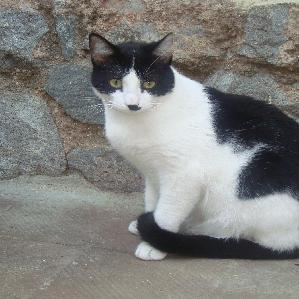
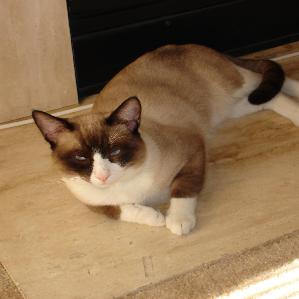
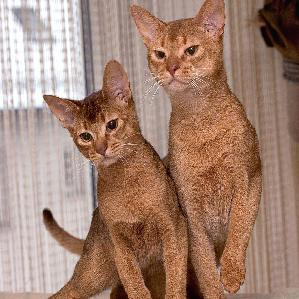
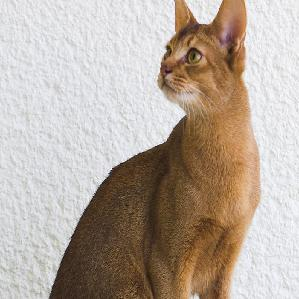
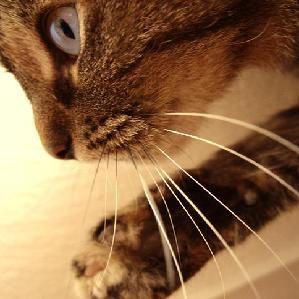
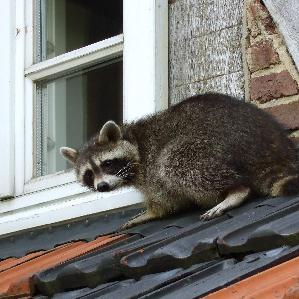
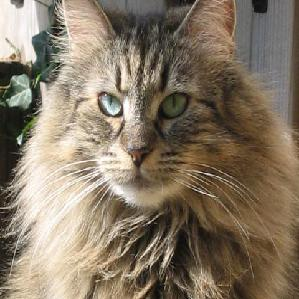
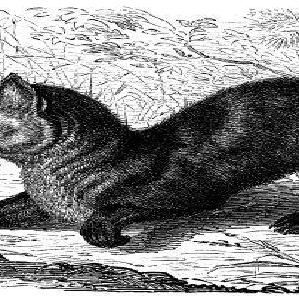
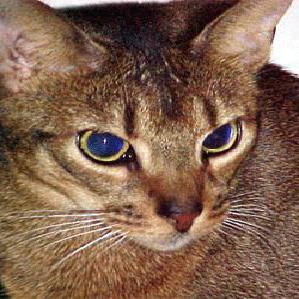
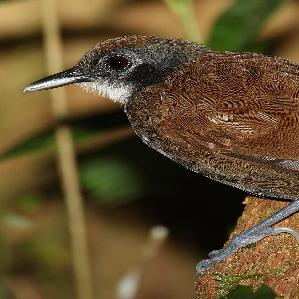

In [75]:
html = []
for idx, dist in zip(indices[0], distances[0]):
    b = BytesIO()
    valid_images[idx].save(b, format='jpeg')
    b64_img = base64.b64encode(b.getvalue()).decode('utf-8')
    html.append("<img src = 'data:image/jpg;base64,{0}'/>".format(b64_img))

HTML(''.join(html))

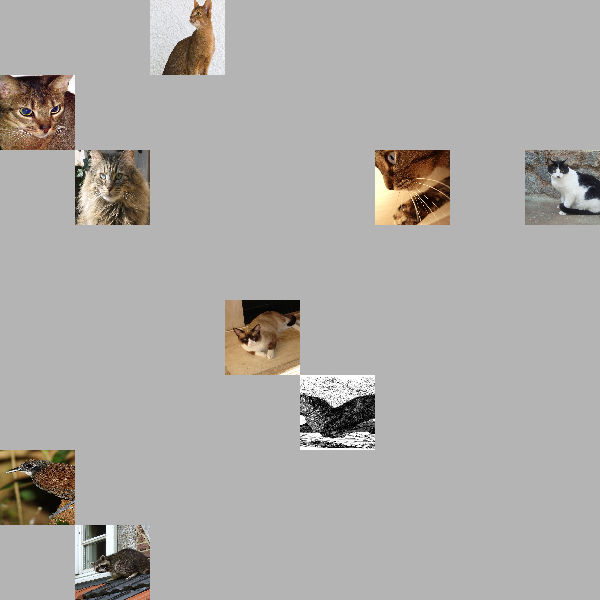

In [80]:
#将图片转换为TGB格式并显示出来
vectors64 = np.asarray([vectors[idx] for idx in indices[0]])
svd = TruncatedSVD(n_components = 2)
vectors64_transformed = svd.fit_transform(vectors64)

img = Image.new('RGB', (8*75, 8*75), (180, 180, 180))
mins = np.min(vectors64_transformed, axis = 0)
maxs = np.max(vectors64_transformed, axis = 0)
xys = (vectors64_transformed - mins) / (maxs - mins)

for idx, (x,y) in zip(indices[0] , xys):
    x = int(x * 7) * 75
    y = int(y * 7) * 75
    img.paste(valid_images[idx].resize((75, 75)), (x, y))
    
img